In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import matplotlib.cm as cm
import fnmatch
import os
import numpy as np
import librosa
import matplotlib.pyplot as plt
import librosa.display
from sklearn.manifold import TSNE
import json

In [48]:
def get_features(y, sr):
    # y = y[0:sr]  # analyze just first second
    S = librosa.feature.melspectrogram(y, sr=sr, n_mels=128)
    log_S = librosa.amplitude_to_db(S, ref=np.max)
    centroid = librosa.feature.spectral_centroid(y, sr)
    centroid = np.mean(centroid)
    bandwidth = librosa.feature.spectral_bandwidth(y,sr)
    bandwidth = np.mean(bandwidth)
    contrast = librosa.feature.spectral_contrast(y,sr)
    contrast = np.mean(contrast)
    flatness = librosa.feature.spectral_flatness(y)
    flatness = np.mean(flatness)
    feature_vector = [centroid, bandwidth, contrast, flatness]
    # mfcc = librosa.feature.mfcc(S=log_S, n_mfcc=13)
    # delta_mfcc = librosa.feature.delta(mfcc, mode='nearest')
    # delta2_mfcc = librosa.feature.delta(mfcc, order=2, mode='nearest')
    # feature_vector = np.concatenate((np.mean(mfcc,1), np.mean(delta_mfcc,1), np.mean(delta2_mfcc,1)))
    # feature_vector = (feature_vector-np.mean(feature_vector)) / np.std(feature_vector)
    return feature_vector

In [125]:
source_audio = "D:/Yanni/YanniBestOf/Yanni - Voyage.mp3"

In [126]:
hop_length = 512
y, sr = librosa.load(source_audio)


In [127]:

onset_strengths = librosa.onset.onset_strength(y=y, sr=sr, hop_length=hop_length)


In [128]:
onsets = [0]
local_min_index = 0
sensitivity = 20
min_length = 20
for index in range(sensitivity, len(onset_strengths) - sensitivity):
    local_max = np.amax(onset_strengths[index-sensitivity: index])
    
    if onset_strengths[index-1] > onset_strengths[index] < onset_strengths[index+1]:
        local_min_index = index
    if onset_strengths[index] > local_max and not onsets[-1] == local_min_index:
        onsets.append(local_min_index)
        if (onsets[-1] - onsets[-2]) < min_length:
            onsets.pop(-2)

times = [hop_length * onset / sr for onset in onsets]

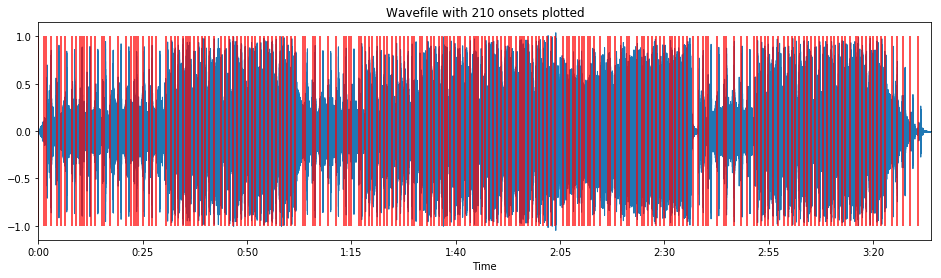

In [129]:
plt.figure(figsize=(16,4))
plt.subplot(1, 1, 1)
librosa.display.waveplot(y, sr=sr)
plt.vlines(times, -1, 1, color='r', alpha=0.9, label='Onsets')
plt.title('Wavefile with %d onsets plotted' % len(times))
plt.show()

In [8]:
len(onsets)

364

In [130]:
feature_vectors = []
centroids = []
bandwidths = []
contrasts = []
flatnesses = []
all_features = []
for i in range(len(onsets)-1):
    idx_y1 = onsets[i  ]*hop_length
    idx_y2 = onsets[i+1]*hop_length
    y_interval = y[idx_y1:idx_y2]
    features = get_features(y_interval, sr)
    centroids.append(features[0])
    bandwidths.append(features[1])
    contrasts.append(features[2])
    flatnesses.append(features[3])
    
    feature_vectors.append({'index':idx_y1, "endIndex":idx_y2, "features":features})
    if i % 50 == 0:
        print(f"analyzed {i+1}/{len(onsets)-1} = {idx_y1}")

centroids = (centroids-np.mean(centroids)) / np.std(centroids)
bandwidths = (bandwidths-np.mean(bandwidths)) / np.std(bandwidths)
contrasts = (contrasts-np.mean(contrasts)) / np.std(contrasts)
flatnesses = (flatnesses-np.mean(flatnesses)) / np.std(flatnesses)

for i in range(len(onsets)-1):
    idx_y1 = onsets[i  ]*hop_length
    idx_y2 = onsets[i+1]*hop_length
    features = [centroids[i], bandwidths[i], contrasts[i], flatnesses[i]]
    all_features.append(features)
    feature_vectors.append({'index':idx_y1, "endIndex":idx_y2, "features":features})


analyzed 1/209 = 0
analyzed 51/209 = 1131008
analyzed 101/209 = 2216960
analyzed 151/209 = 3243520
analyzed 201/209 = 4391936
[[0.7002424592137183, -1.2613401905727382, 1.9878628445577373, 6.6205635], [0.43135309875417305, -1.4762243443529883, 2.306927579752311, -0.63647723], [-0.1281596761616447, -0.5719169545905702, -0.36903610152447097, 0.31624377], [-1.7855167368153533, -1.9322474684045279, 0.5796753620955015, -0.9129114], [-1.876566973291686, -2.0465202934193543, 0.9289712593138327, -0.91308224], [-1.9830028414427672, -2.2130043136499205, 0.45455957587601903, -0.9143182], [-1.9530429646048044, -2.2279373684528374, 1.071621451208933, -0.9143466], [-1.941429504140561, -2.0565267495517157, 0.5156767369105122, -0.91269815], [-1.9816480211582277, -2.334752034837908, 0.647386064544569, -0.91538364], [-1.8380236024579295, -1.7080335248365646, -0.2694660191242489, -0.9112619], [-2.0396258578782502, -2.454826958483016, 1.8952052716742562, -0.9160066], [-1.8147775263055277, -2.1249181784028

In [150]:
features_matrix = [f["features"] for f in feature_vectors]

model = TSNE(n_components=2, learning_rate=50, perplexity=4, verbose=2, angle=0.1).fit_transform(features_matrix)

x_axis, y_axis = model[:,0], model[:,1]
x_norm = (x_axis - np.min(x_axis)) / (np.max(x_axis) - np.min(x_axis))
y_norm = (y_axis - np.min(y_axis)) / (np.max(y_axis) - np.min(y_axis))

data = [{"index":f['index'], "endIndex":f['endIndex'], "point":[float(x), float(y)]} for f, x, y, in zip(feature_vectors, x_norm, y_norm)]

[t-SNE] Computing 13 nearest neighbors...
[t-SNE] Indexed 418 samples in 0.000s...
[t-SNE] Computed neighbors for 418 samples in 0.002s...
[t-SNE] Computed conditional probabilities for sample 418 / 418
[t-SNE] Mean sigma: 0.241416
[t-SNE] Computed conditional probabilities in 0.005s
[t-SNE] Iteration 50: error = 76.0937347, gradient norm = 0.4237376 (50 iterations in 0.252s)
[t-SNE] Iteration 100: error = 64.0884247, gradient norm = 0.2658376 (50 iterations in 0.168s)
[t-SNE] Iteration 150: error = 60.1393967, gradient norm = 0.2157749 (50 iterations in 0.144s)
[t-SNE] Iteration 200: error = 58.0385895, gradient norm = 0.2050871 (50 iterations in 0.126s)
[t-SNE] Iteration 250: error = 56.7204323, gradient norm = 0.1761890 (50 iterations in 0.128s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 56.720432
[t-SNE] Iteration 300: error = 0.7169561, gradient norm = 0.0023133 (50 iterations in 0.189s)
[t-SNE] Iteration 350: error = 0.4966812, gradient norm = 0.0009007 (

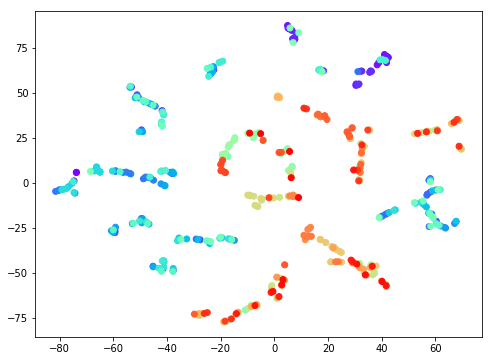

In [151]:
colors = cm.rainbow(np.linspace(0, 1, len(x_axis)))
plt.figure(figsize = (8,6))
plt.scatter(x_axis, y_axis, color=colors)

plt.show()

In [112]:
# data
left= [data[i] for i, t in enumerate(data) if x_axis[i] > 0]
right = [data[i] for i, t in enumerate(data) if x_axis[i] < 0]

In [124]:
x_axis

array([ 40.556023 ,  36.54676  ,  35.953785 ,  40.021255 ,  41.437885 ,
        40.37271  ,  41.00764  ,  41.3638   ,  28.11285  ,  38.338676 ,
        40.243908 ,  40.07445  ,  32.806435 ,  33.713318 ,  39.63824  ,
        40.897522 ,  40.953583 ,  40.466568 ,  40.91934  ,  36.042027 ,
        38.298565 ,  38.834198 ,  40.42346  ,  39.101254 ,  39.40685  ,
        39.977135 ,  38.806988 ,  38.078377 ,  39.89417  ,  40.834095 ,
        38.969357 ,  26.35697  ,  27.360928 ,  31.55673  ,  30.341763 ,
        28.010818 ,  27.696562 ,  30.360804 ,  40.11622  ,  23.345375 ,
        30.80744  ,  38.115696 ,  39.283325 ,  39.75117  ,  38.680405 ,
        31.307072 ,  32.098286 ,  39.407307 ,  13.882454 ,  29.285957 ,
        39.55547  ,  25.052265 ,   9.182245 ,  32.057228 ,  27.616781 ,
        27.31679  ,   4.3536897,  32.1257   ,  39.245476 ,  40.29168  ,
        39.66364  ,  40.424656 ,  34.71026  ,  30.926311 ,  27.340134 ,
        30.091625 ,  33.49298  ,  30.883331 ,  36.16069  ,  30.3

In [116]:

len(x_axis)

726

In [152]:
def sortRule(val):
    return val['point'][0]

def sortTwo(val):
    return val['point'][1]

data_sorted_x = data
data_sorted_y = data
data_sorted_x.sort(key = sortRule)
data_sorted_y.sort(key = sortTwo)


In [101]:
left

[{'index': 2106368, 'endIndex': 2118656, 'point': [0.39489060640335083, 0.0]},
 {'index': 151552,
  'endIndex': 163328,
  'point': [0.4022924602031708, 0.0007515149773098528]},
 {'index': 401920,
  'endIndex': 426496,
  'point': [0.4115481376647949, 0.004402755759656429]},
 {'index': 2083328,
  'endIndex': 2106368,
  'point': [0.38033872842788696, 0.005022669676691294]},
 {'index': 1384448,
  'endIndex': 1399296,
  'point': [0.39366936683654785, 0.00672418437898159]},
 {'index': 1399296,
  'endIndex': 1417728,
  'point': [0.4031754434108734, 0.009009262546896935]},
 {'index': 2053632,
  'endIndex': 2072576,
  'point': [0.36676594614982605, 0.009393151849508286]},
 {'index': 335360,
  'endIndex': 360960,
  'point': [0.40708494186401367, 0.012146074324846268]},
 {'index': 5551616,
  'endIndex': 5586432,
  'point': [0.35897257924079895, 0.013743802905082703]},
 {'index': 2072576,
  'endIndex': 2083328,
  'point': [0.371265172958374, 0.014134019613265991]},
 {'index': 1359872,
  'endIndex'

In [153]:
sortedAudioX = []
for i, sample in enumerate(left):
    audioSampleX = y[sample['index']:sample['endIndex']]
    sortedAudioX.extend(audioSampleX)
sortedAudioX = np.asarray(sortedAudioX)

sortedAudioY = []
for i, sample in enumerate(right):
    audioSampleY = y[sample['index']:sample['endIndex']]
    sortedAudioY.extend(audioSampleY)
sortedAudioY = np.asarray(sortedAudioY)

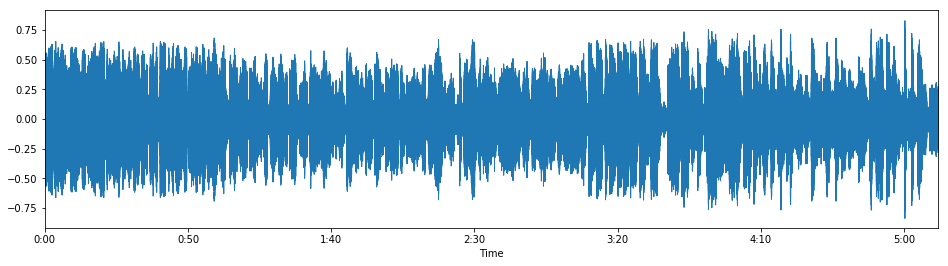

In [24]:
plt.figure(figsize=(16,4))
plt.subplot(1, 1, 1)
librosa.display.waveplot(sortedAudioX, sr=sr)

In [53]:
sortedAudio

[-0.113879204,
 -0.09635646,
 -0.053441044,
 -0.0078731645,
 0.04014782,
 0.06382137,
 0.07127889,
 0.07315172,
 0.08816066,
 0.12949835,
 0.19012369,
 0.26488018,
 0.3517335,
 0.4105923,
 0.41721028,
 0.39539495,
 0.34921956,
 0.3112198,
 0.3079766,
 0.3297355,
 0.36582372,
 0.39349997,
 0.40469688,
 0.40404966,
 0.3895044,
 0.398733,
 0.43108812,
 0.48035067,
 0.5281696,
 0.56214666,
 0.578426,
 0.5603579,
 0.53228384,
 0.4871523,
 0.46102464,
 0.4448067,
 0.4168592,
 0.3799045,
 0.33725202,
 0.28759637,
 0.22829966,
 0.18066604,
 0.124619134,
 0.09020497,
 0.07913221,
 0.08506555,
 0.11598446,
 0.15247034,
 0.17771809,
 0.19303124,
 0.20801163,
 0.20566106,
 0.20098065,
 0.1835794,
 0.14674188,
 0.11331075,
 0.06923296,
 0.032559823,
 0.024273533,
 0.029101694,
 0.059523687,
 0.10810879,
 0.12825978,
 0.120375946,
 0.104803704,
 0.09356627,
 0.0853288,
 0.0740336,
 0.05330648,
 0.029291904,
 0.004989542,
 -0.014803198,
 -0.005222686,
 0.036343895,
 0.082027264,
 0.103181906,
 0.1072

In [154]:
librosa.output.write_wav('./sortedAudioXVoyage1.wav', sortedAudioX, sr)
librosa.output.write_wav('./sortedAudioYVoyage1.wav', sortedAudioY, sr)